In [2]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from sklearn.model_selection import train_test_split
from scipy.stats import spearmanr
from sklearn.model_selection import ParameterGrid
import matplotlib.pyplot as plt

# Check if GPU is available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {device}')

Using device: cuda


In [ ]:
# Load datasets
data_dir = "/home/vivian.chu/vivian-sandbox/other/xAI-cancer-competition/.data"
# train_data = pd.read_csv(f"{data_dir}/train.csv")
# train_targets = pd.read_csv(f"{data_dir}/train_targets.csv")
train_data = pd.read_csv(f"{data_dir}/train_375.csv")
train_targets = pd.read_csv(f"{data_dir}/targets_375.csv")
test_data = pd.read_csv(f"{data_dir}/test.csv")

: 

: 

In [ ]:
train_data.head()

,A1BG,A1CF,A2M,A2ML1,A3GALT2,A4GALT,A4GNT,AAAS,AACS,AADAC,...,ZW10,ZWILCH,ZWINT,ZXDA,ZXDB,ZXDC,ZYG11A,ZYG11B,ZYX,ZZEF1
0,1.672481,45.412546,9.377504,0.860362,0.156075,0.358733,0.013006,90.484463,119.760414,0.000000,...,38.069286,118.897181,201.401740,2.789229,13.546617,40.176298,0.832672,54.266923,27.312810,74.123751
1,0.545643,15.886006,0.126553,0.731387,0.000000,3.006263,0.015819,43.455131,37.971081,0.015819,...,40.892433,72.780020,95.990439,4.139704,23.717772,40.655146,0.547275,45.944219,59.511226,66.289158
2,0.795200,0.182806,0.534622,0.239157,0.027417,20.203002,0.342707,74.806003,56.297983,0.027417,...,18.122326,56.826586,120.221485,16.671474,19.477221,25.798955,4.028667,22.369665,138.546988,69.946391
3,9.983922,0.222700,0.451019,0.152793,0.233698,1.174855,0.068735,53.228255,36.978543,0.068735,...,47.234577,63.179324,89.121585,1.397236,4.197779,16.001469,0.097534,32.175188,176.770218,62.978656
4,0.253195,0.097002,0.157080,9.779361,0.024166,19.358564,0.000000,50.132805,59.941285,0.326244,...,44.127501,43.827808,93.994478,2.305342,10.937742,21.882504,0.575731,23.764585,223.041089,52.976574


: 

: 

In [ ]:
test_data.head()

,sampleId,A1BG,A1CF,A2M,A2ML1,A3GALT2,A4GALT,A4GNT,AAAS,AACS,...,ZW10,ZWILCH,ZWINT,ZXDA,ZXDB,ZXDC,ZYG11A,ZYG11B,ZYX,ZZEF1
0,TS1,1.446057,75.700445,0.031116,0.471972,0.014860,3.129831,0.000000,54.031837,130.140472,...,27.105080,39.252909,27.238822,3.305222,20.211109,103.382698,0.263830,22.459802,37.039151,143.833393
1,TS2,7.201269,0.354029,0.074407,0.453273,0.108228,11.557571,0.344976,43.575264,45.155525,...,24.459509,20.147702,4.051783,7.994292,30.507789,30.844956,18.978149,88.545037,110.433059,32.066500
2,TS3,6.835308,0.121081,0.000000,0.211975,0.020079,12.372666,0.066928,34.581955,37.123022,...,14.771119,27.387161,21.477355,6.518653,25.091676,29.635939,7.931413,73.418524,282.685845,77.289198
3,TS4,6.384288,0.132942,0.018201,0.207608,0.007283,4.364313,0.203914,49.908053,36.949086,...,26.690940,18.067079,27.841600,3.410666,12.014003,28.533453,0.883263,36.657930,198.743729,69.446998
4,TS5,4.538481,1.354367,0.007254,0.237628,0.021695,3.881963,0.267576,39.319195,55.127152,...,33.244498,49.214787,61.607545,8.412126,28.404872,19.482419,16.771958,46.033522,196.559752,36.681241


: 

: 

In [ ]:
train_data = nn.log1p(train_data)

: 

: 

In [ ]:
# Clean column names and merge targets with train data
# train_data.rename(columns={'Unnamed: 0': 'sample'}, inplace=True)
# train_data['sample'] = train_data['sample'].astype(str)
# train_targets['sample'] = train_targets['sample'].astype(str)
test_data['sampleId'] = test_data['sampleId'].astype(str)

: 

: 

In [ ]:
# Prepare train and test datasets
train_features = train_data
train_labels = train_targets['AAC']
test_features = test_data.drop(columns=['sampleId'])

# Set input dimension
input_dim = train_features.shape[1]

: 

: 

In [ ]:
# Split dataset into train and validation (80% train, 20% validation)
X_train, X_val, y_train, y_val = train_test_split(train_features, train_labels, test_size=0.2, random_state=42)

: 

: 

In [ ]:
# Define the Dataset class
class GeneExpressionDataset(Dataset):
    def __init__(self, data, targets=None):
        self.data = data.values.astype(np.float32)
        self.targets = targets.values.astype(np.float32) if targets is not None else None

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        if self.targets is not None:
            return torch.tensor(self.data[idx]), torch.tensor(self.targets[idx])
        else:
            return torch.tensor(self.data[idx])

: 

: 

In [ ]:
# Create Dataset and DataLoader objects
train_dataset = GeneExpressionDataset(X_train, y_train)
val_dataset = GeneExpressionDataset(X_val, y_val)
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)  # Reduced batch size to introduce more training noise
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False)
test_loader = DataLoader(GeneExpressionDataset(test_features), batch_size=16, shuffle=False)

: 

: 

In [ ]:
# Define the model with Transformer and additional improvements
class DrugResponseModel(nn.Module):
    def __init__(self, input_dim, embed_dim=256, num_heads=8, num_layers=4, ff_dim=64, dropout=0.1):
        super(DrugResponseModel, self).__init__()
        self.embedding = nn.Linear(input_dim, embed_dim)
        self.positional_encoding = nn.Parameter(torch.randn(1, embed_dim))
        self.transformer_layer = nn.TransformerEncoderLayer(d_model=embed_dim, nhead=num_heads, dim_feedforward=ff_dim, dropout=dropout)
        self.transformer = nn.TransformerEncoder(self.transformer_layer, num_layers=num_layers)
        self.fc1 = nn.Linear(embed_dim, 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, 1)
        self.relu = nn.ReLU()
        self.dropout1 = nn.Dropout(dropout)
        self.dropout2 = nn.Dropout(dropout)
        self.dropout3 = nn.Dropout(dropout)
        self.layer_norm = nn.LayerNorm(embed_dim, eps=1e-6)

    def forward(self, x):
        x = self.embedding(x) + self.positional_encoding  # Embedding with positional encoding
        x = self.layer_norm(x)  # Layer normalization instead of batch normalization
        x = x.unsqueeze(1)  # Add sequence dimension
        x = self.transformer(x)
        x = x.mean(dim=1)  # Global average pooling
        x = self.relu(self.fc1(x))
        x = self.dropout1(x)
        x = self.relu(self.fc2(x))
        x = self.dropout2(x)
        x = self.fc3(x)
        return x

: 

: 

In [ ]:
# Training loop with improved model
from torch.optim.lr_scheduler import ReduceLROnPlateau

def train_model(model, train_loader, val_loader, criterion, optimizer, epochs=50, early_stopping_patience=10):
    train_corrs = []
    val_corrs = []
    best_val_corr = -1
    patience_counter = 0
    scheduler = ReduceLROnPlateau(optimizer, mode='max', factor=0.5, patience=3, verbose=True)
    
    for epoch in range(epochs):
        model.train()
        epoch_loss = 0
        for features, labels in train_loader:
            features, labels = features.to(device), labels.to(device)
            # Adding Gaussian noise to features to help reduce overfitting
            features += torch.normal(0, 0.01, size=features.shape).to(device)
            optimizer.zero_grad()
            outputs = model(features)
            loss = criterion(outputs.view(-1), labels)
            loss.backward()
            optimizer.step()
            epoch_loss += loss.item()
        
        # Evaluate on validation set
        model.eval()
        val_loss = 0
        with torch.no_grad():
            for features, labels in val_loader:
                features, labels = features.to(device), labels.to(device)
                outputs = model(features)
                loss = criterion(outputs.view(-1), labels)
                val_loss += loss.item()

        # Calculate Spearman correlation for both training and validation sets
        train_corr = evaluate_model(model, train_loader, print_corr=False)
        val_corr = evaluate_model(model, val_loader, print_corr=False)
        train_corrs.append(train_corr)
        val_corrs.append(val_corr)
        
        print(f'Epoch {epoch+1}/{epochs}, Train Loss: {epoch_loss/len(train_loader):.4f}, Validation Loss: {val_loss/len(val_loader):.4f}, Train Corr: {train_corr:.4f}, Val Corr: {val_corr:.4f}')
        
        # Scheduler step
        scheduler.step(val_corr)

        # Early Stopping Logic
        if val_corr > best_val_corr:
            best_val_corr = val_corr
            patience_counter = 0
        else:
            patience_counter += 1
        if patience_counter >= early_stopping_patience:
            print(f'Early stopping at epoch {epoch+1}')
            break
    
    # Plot Spearman correlation
    plt.figure(figsize=(10, 5))
    plt.plot(range(1, len(train_corrs) + 1), train_corrs, label='Train Spearman Correlation')
    plt.plot(range(1, len(val_corrs) + 1), val_corrs, label='Validation Spearman Correlation')
    plt.xlabel('Epoch')
    plt.ylabel('Spearman Correlation')
    plt.title('Spearman Correlation Over Epochs')
    plt.legend()
    plt.show()

: 

: 

In [ ]:
# Evaluation function
def evaluate_model(model, loader, print_corr=True):
    model.eval()
    all_labels = []
    all_preds = []
    with torch.no_grad():
        for features, labels in loader:
            features, labels = features.to(device), labels.to(device)
            outputs = model(features)
            all_labels.extend(labels.cpu().numpy())
            all_preds.extend(outputs.view(-1).cpu().numpy())
    spearman_corr, _ = spearmanr(all_labels, all_preds)
    if spearman_corr is None or np.isnan(spearman_corr):
        spearman_corr = -1  # Set a default value if correlation cannot be computed
    if print_corr:
        print(f'Spearman Correlation: {spearman_corr:.4f}')
    return spearman_corr

: 

: 

In [ ]:
# Hyperparameter Sweep
param_grid = {
    'embed_dim': [64],
    'num_heads': [4,8],
    'num_layers': [2,4],
    'ff_dim': [32],
    'dropout': [0.1],
    'learning_rate': [0.00001]
}

best_val_corr = -1
best_params = None


: 

: 

Training with parameters: {'dropout': 0.1, 'embed_dim': 64, 'ff_dim': 32, 'learning_rate': 1e-05, 'num_heads': 4, 'num_layers': 2}
Epoch 1/1000, Train Loss: 0.0864, Validation Loss: 0.0703, Train Corr: 0.2046, Val Corr: 0.3255
Epoch 2/1000, Train Loss: 0.0751, Validation Loss: 0.0745, Train Corr: 0.2282, Val Corr: 0.3407
Epoch 3/1000, Train Loss: 0.0800, Validation Loss: 0.0702, Train Corr: 0.3433, Val Corr: 0.3909
Epoch 4/1000, Train Loss: 0.0712, Validation Loss: 0.0667, Train Corr: 0.4123, Val Corr: 0.4415
Epoch 5/1000, Train Loss: 0.0661, Validation Loss: 0.0671, Train Corr: 0.4589, Val Corr: 0.4781
Epoch 6/1000, Train Loss: 0.0660, Validation Loss: 0.0661, Train Corr: 0.4655, Val Corr: 0.4678
Epoch 7/1000, Train Loss: 0.0658, Validation Loss: 0.0660, Train Corr: 0.4992, Val Corr: 0.4954
Epoch 8/1000, Train Loss: 0.0642, Validation Loss: 0.0649, Train Corr: 0.5206, Val Corr: 0.5244
Epoch 9/1000, Train Loss: 0.0650, Validation Loss: 0.0654, Train Corr: 0.5291, Val Corr: 0.5181
Epoch

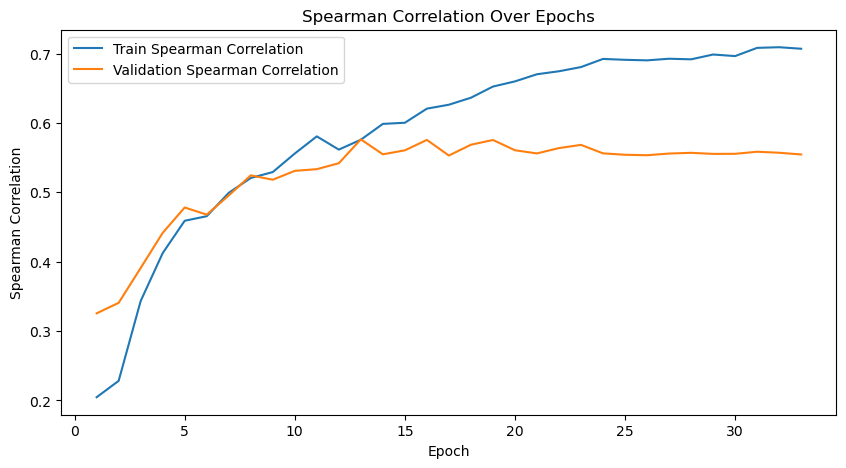

Spearman Correlation: 0.5545
Training with parameters: {'dropout': 0.1, 'embed_dim': 64, 'ff_dim': 32, 'learning_rate': 1e-05, 'num_heads': 4, 'num_layers': 4}
Epoch 1/1000, Train Loss: 0.0783, Validation Loss: 0.0716, Train Corr: 0.0560, Val Corr: 0.2737
Epoch 2/1000, Train Loss: 0.0701, Validation Loss: 0.0693, Train Corr: 0.2242, Val Corr: 0.4005
Epoch 3/1000, Train Loss: 0.0706, Validation Loss: 0.0680, Train Corr: 0.2919, Val Corr: 0.5180
Epoch 4/1000, Train Loss: 0.0720, Validation Loss: 0.0700, Train Corr: 0.3312, Val Corr: 0.5105
Epoch 5/1000, Train Loss: 0.0705, Validation Loss: 0.0685, Train Corr: 0.3987, Val Corr: 0.5281
Epoch 6/1000, Train Loss: 0.0669, Validation Loss: 0.0688, Train Corr: 0.4141, Val Corr: 0.5364
Epoch 7/1000, Train Loss: 0.0690, Validation Loss: 0.0663, Train Corr: 0.4379, Val Corr: 0.5504
Epoch 8/1000, Train Loss: 0.0677, Validation Loss: 0.0651, Train Corr: 0.4561, Val Corr: 0.5651
Epoch 9/1000, Train Loss: 0.0716, Validation Loss: 0.0665, Train Corr: 0

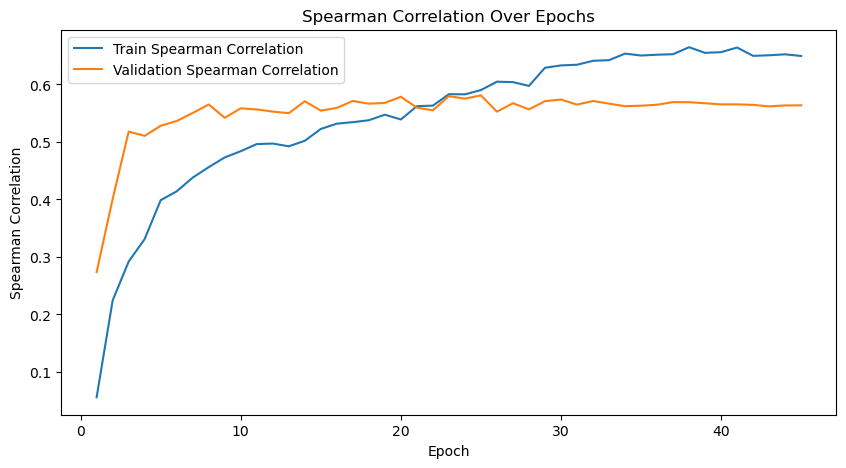

Spearman Correlation: 0.5637
Training with parameters: {'dropout': 0.1, 'embed_dim': 64, 'ff_dim': 32, 'learning_rate': 1e-05, 'num_heads': 8, 'num_layers': 2}
Epoch 1/1000, Train Loss: 0.0920, Validation Loss: 0.0757, Train Corr: 0.0906, Val Corr: 0.1923
Epoch 2/1000, Train Loss: 0.0763, Validation Loss: 0.0717, Train Corr: 0.2514, Val Corr: 0.3459
Epoch 3/1000, Train Loss: 0.0772, Validation Loss: 0.0698, Train Corr: 0.3439, Val Corr: 0.4763
Epoch 4/1000, Train Loss: 0.0753, Validation Loss: 0.0708, Train Corr: 0.3847, Val Corr: 0.5066
Epoch 5/1000, Train Loss: 0.0683, Validation Loss: 0.0668, Train Corr: 0.4168, Val Corr: 0.4808
Epoch 6/1000, Train Loss: 0.0696, Validation Loss: 0.0665, Train Corr: 0.4360, Val Corr: 0.4713
Epoch 7/1000, Train Loss: 0.0706, Validation Loss: 0.0671, Train Corr: 0.4834, Val Corr: 0.5157
Epoch 8/1000, Train Loss: 0.0712, Validation Loss: 0.0678, Train Corr: 0.4962, Val Corr: 0.5107
Epoch 9/1000, Train Loss: 0.0724, Validation Loss: 0.0648, Train Corr: 0

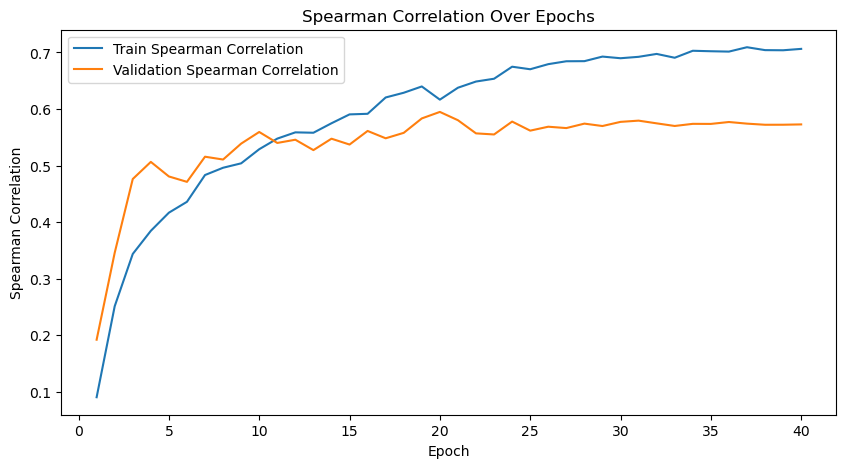

Spearman Correlation: 0.5728
Training with parameters: {'dropout': 0.1, 'embed_dim': 64, 'ff_dim': 32, 'learning_rate': 1e-05, 'num_heads': 8, 'num_layers': 4}
Epoch 1/1000, Train Loss: 0.0762, Validation Loss: 0.0700, Train Corr: 0.1849, Val Corr: 0.4267
Epoch 2/1000, Train Loss: 0.0759, Validation Loss: 0.0686, Train Corr: 0.2864, Val Corr: 0.5066
Epoch 3/1000, Train Loss: 0.0752, Validation Loss: 0.0704, Train Corr: 0.2606, Val Corr: 0.3989
Epoch 4/1000, Train Loss: 0.0708, Validation Loss: 0.0747, Train Corr: 0.3568, Val Corr: 0.4136
Epoch 5/1000, Train Loss: 0.0711, Validation Loss: 0.0668, Train Corr: 0.3651, Val Corr: 0.4850
Epoch 6/1000, Train Loss: 0.0728, Validation Loss: 0.0679, Train Corr: 0.4250, Val Corr: 0.4967
Epoch 7/1000, Train Loss: 0.0703, Validation Loss: 0.0662, Train Corr: 0.4407, Val Corr: 0.5031
Epoch 8/1000, Train Loss: 0.0655, Validation Loss: 0.0677, Train Corr: 0.4371, Val Corr: 0.5273
Epoch 9/1000, Train Loss: 0.0654, Validation Loss: 0.0642, Train Corr: 0

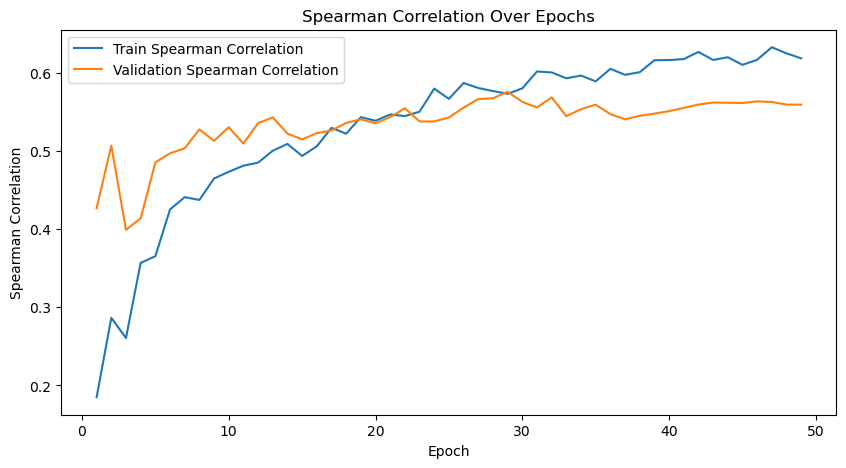

Spearman Correlation: 0.5590
Best Validation Spearman Correlation: 0.5895
Best Parameters: {'dropout': 0.1, 'embed_dim': 64, 'ff_dim': 32, 'learning_rate': 1e-05, 'num_heads': 4, 'num_layers': 2}


: 

: 

In [ ]:
for params in ParameterGrid(param_grid):
    print(f"Training with parameters: {params}")
    model = DrugResponseModel(input_dim, embed_dim=params['embed_dim'], num_heads=params['num_heads'], 
                              num_layers=params['num_layers'], ff_dim=params['ff_dim'], dropout=params['dropout']).to(device)
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=params['learning_rate'], weight_decay=1e-4)
    
    train_model(model, train_loader, val_loader, criterion, optimizer, epochs=1000, early_stopping_patience=20)
    val_corr = evaluate_model(model, val_loader)
    
    if val_corr > best_val_corr:
        best_val_corr = val_corr
        best_params = params

print(f"Best Validation Spearman Correlation: {best_val_corr:.4f}")
print(f"Best Parameters: {best_params}")

Training the best model with full training set
Epoch 1/100, Train Loss: 0.0115, Validation Loss: 0.0096, Train Corr: 0.2277, Val Corr: 0.2613
Epoch 2/100, Train Loss: 0.0124, Validation Loss: 0.0079, Train Corr: 0.3480, Val Corr: 0.4580
Epoch 3/100, Train Loss: 0.0094, Validation Loss: 0.0078, Train Corr: 0.3695, Val Corr: 0.4933
Epoch 4/100, Train Loss: 0.0097, Validation Loss: 0.0070, Train Corr: 0.4079, Val Corr: 0.5278
Epoch 5/100, Train Loss: 0.0091, Validation Loss: 0.0069, Train Corr: 0.4546, Val Corr: 0.5217
Epoch 6/100, Train Loss: 0.0088, Validation Loss: 0.0068, Train Corr: 0.4700, Val Corr: 0.5515
Epoch 7/100, Train Loss: 0.0088, Validation Loss: 0.0068, Train Corr: 0.4776, Val Corr: 0.5535
Epoch 8/100, Train Loss: 0.0090, Validation Loss: 0.0067, Train Corr: 0.5169, Val Corr: 0.5256
Epoch 9/100, Train Loss: 0.0080, Validation Loss: 0.0072, Train Corr: 0.5519, Val Corr: 0.5149
Epoch 10/100, Train Loss: 0.0076, Validation Loss: 0.0067, Train Corr: 0.5594, Val Corr: 0.5329
Ep

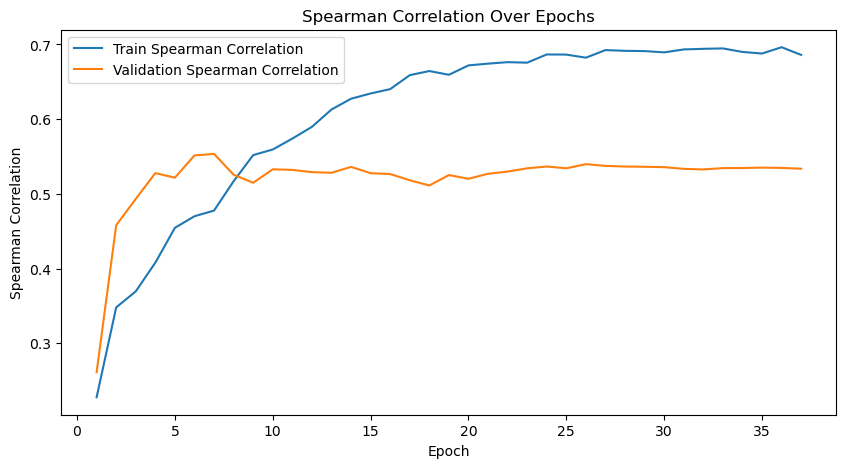

Spearman Correlation: 0.6938


0.6937603609108751

: 

: 

In [ ]:
# Train the best model
print("Training the best model with full training set")
model = DrugResponseModel(input_dim, embed_dim=best_params['embed_dim'], num_heads=best_params['num_heads'], 
                          num_layers=best_params['num_layers'], ff_dim=best_params['ff_dim'], dropout=best_params['dropout']).to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=best_params['learning_rate'], weight_decay=1e-5)
train_model(model, train_loader, val_loader, criterion, optimizer, epochs=100, early_stopping_patience=30)

# Evaluate the model
evaluate_model(model, train_loader)

In [ ]:
# Predict AAC values for the test set
def predict(model, loader):
    model.eval()
    predictions = []
    with torch.no_grad():
        for features in loader:
            features = features.to(device)
            outputs = model(features)
            predictions.extend(outputs.view(-1).cpu().numpy())
    return predictions

test_predictions = predict(model, test_loader)

# Save predictions
out_dir = "/home/vivian.chu/vivian-sandbox/other/xAI-cancer-competition/vivian-models"
pd.DataFrame({'sampleId': test_data['sampleId'], 'AAC': test_predictions}).to_csv(f"{out_dir}/transformer_predictions.csv", index=False)

: 

: 

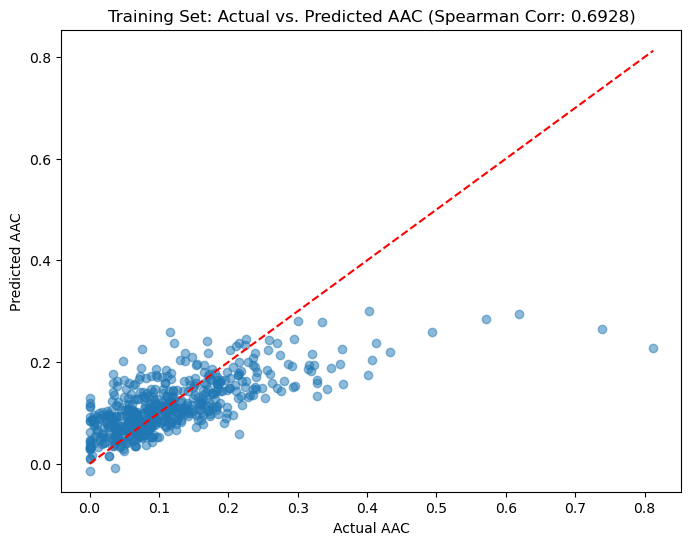

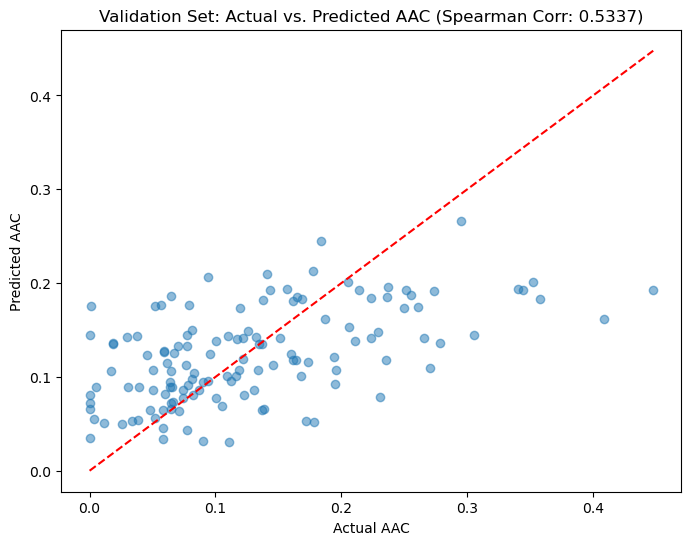

: 

: 

In [ ]:
# Plot actual vs. predicted AAC for the training and validation sets
def plot_actual_vs_predicted(model, loader, title):
    model.eval()
    all_labels = []
    all_preds = []
    with torch.no_grad():
        for features, labels in loader:
            features, labels = features.to(device), labels.to(device)
            outputs = model(features)
            all_labels.extend(labels.cpu().numpy())
            all_preds.extend(outputs.view(-1).cpu().numpy())
    
    spearman_corr, _ = spearmanr(all_labels, all_preds)
    plt.figure(figsize=(8, 6))
    plt.scatter(all_labels, all_preds, alpha=0.5)
    plt.xlabel('Actual AAC')
    plt.ylabel('Predicted AAC')
    plt.title(f'{title} (Spearman Corr: {spearman_corr:.4f})')
    plt.plot([min(all_labels), max(all_labels)], [min(all_labels), max(all_labels)], 'r--')
    plt.show()

# Plot for training and validation sets
plot_actual_vs_predicted(model, train_loader, 'Training Set: Actual vs. Predicted AAC')
plot_actual_vs_predicted(model, val_loader, 'Validation Set: Actual vs. Predicted AAC')